In [1]:
import os, sys
import numpy as np
import nibabel as nb
import h5py
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import plot_funcs
from nilearn import plotting
from numpy import genfromtxt
import pygeodesic
import pygeodesic.geodesic as geodesic
from brainspace.datasets import load_conte69, load_mask
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import reduce_by_labels
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient import GradientMaps

### read-in cortical myelin (in vivo, T1w/T2w) measures across all subjects

In [2]:
ddir = '../data/tout_group'

h1 = h5py.File(os.path.join(ddir, 'H709_mye_cortex.h5'), 'r')

mye_cortex = np.array(h1['data']).T; h1.close()

mye_cortex.shape, mye_cortex.min(), mye_cortex.max()

((709, 360), 0.02919340319931507, 4.150848388671875)

In [3]:
# Glasser Labels
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)
print(labeling.shape, labeling.min(), labeling.max())

# load surfaces
surf_lh, surf_rh = load_conte69()
mask = labeling != 0 # this takes the mask of the left hem only..
mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


(64984,) 0.0 360.0


In [4]:
# get the mean myelin measure across subjects & label to freesurfer
mye_cortex_mean = mye_cortex.mean(axis=0)
print(mye_cortex_mean.shape)

mye_cortex_mean_labeled = map_to_labels(mye_cortex_mean, labeling, mask=mymask) 
mye_cortex_mean_labeled[np.where(mymask == False)] = np.nan
print(mye_cortex_mean_labeled.shape)

(360,)
(64984,)


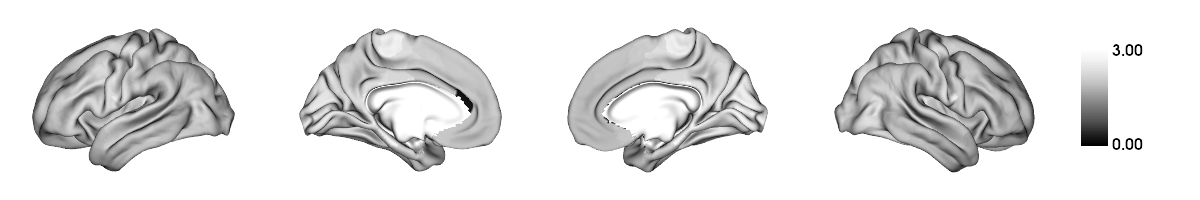

In [5]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = mye_cortex_mean_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'Greys_r', 
                 color_bar = True,
                 color_range = (0., 3),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_cortex_mye.svg'
                 )

### read-in the gradients data of the structural intensity of covariance (sic)

In [6]:
outdir = '../data/tout_group/'

h = h5py.File(os.path.join(outdir, 'Hmean709scovGradients_left.h5'), 'r')
data = np.array(h['data']).T

G1_sic_LSUB = data[0:1024,0]
G1_sic_LCA  = data[1024:1024+2048,0]
G1_sic_LDG  = data[1024+2048:1024+2048+1024,0] 

G2_sic_LSUB = data[0:1024,1]
G2_sic_LCA  = data[1024:1024+2048,1]
G2_sic_LDG  = data[1024+2048:1024+2048+1024,1] 



## G1 (sic)

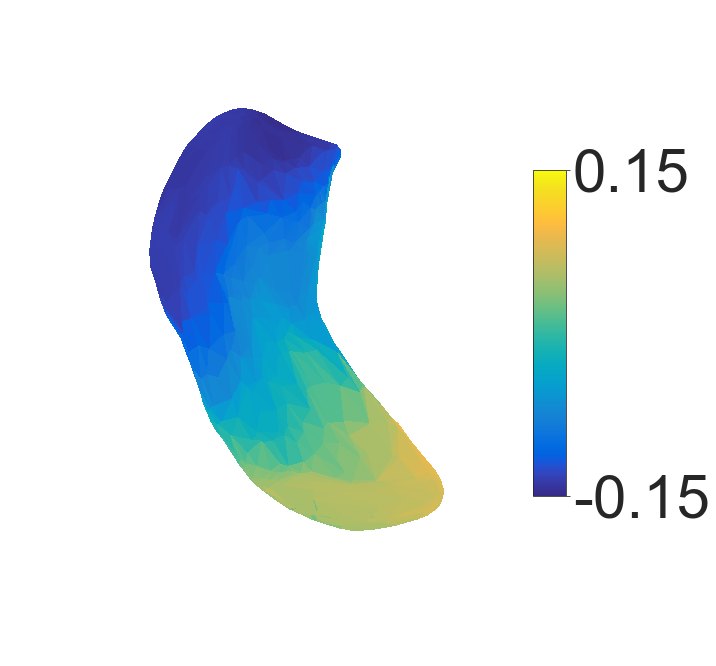

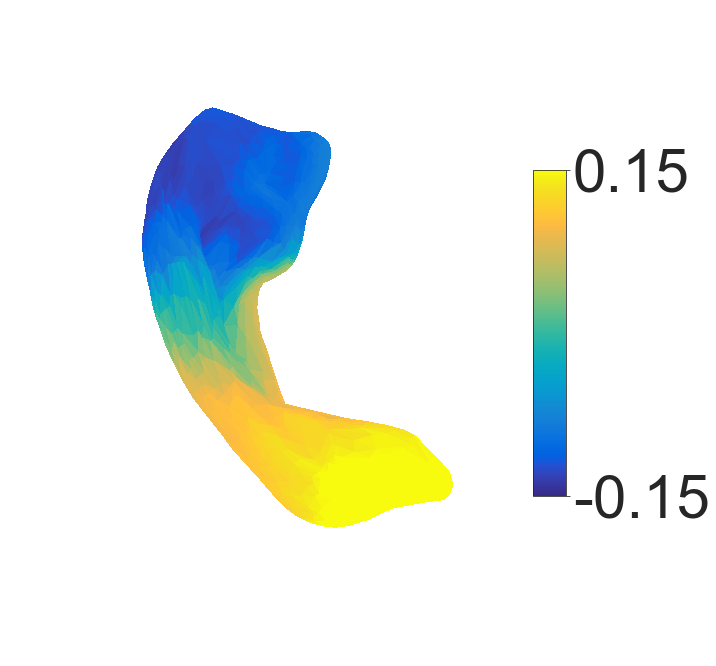

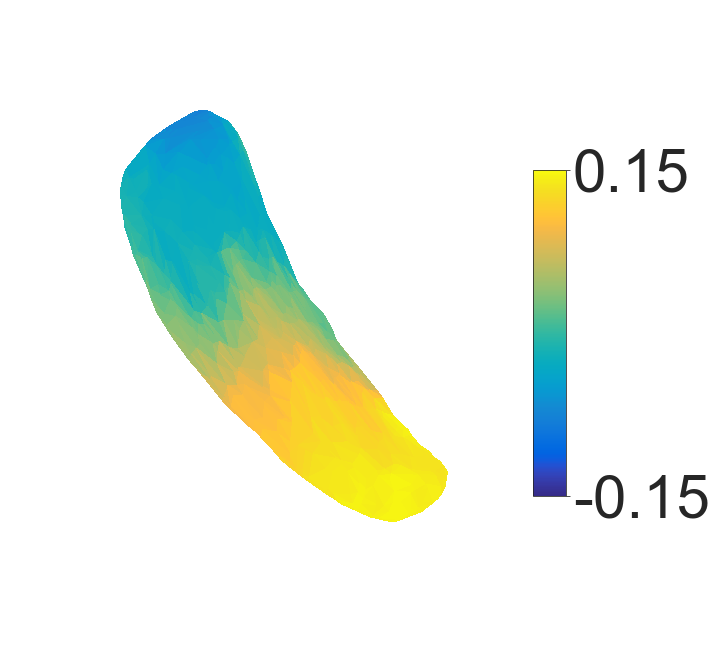

In [7]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G1_sic_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_sic_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)


fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_sic_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)




## G2 (sic)

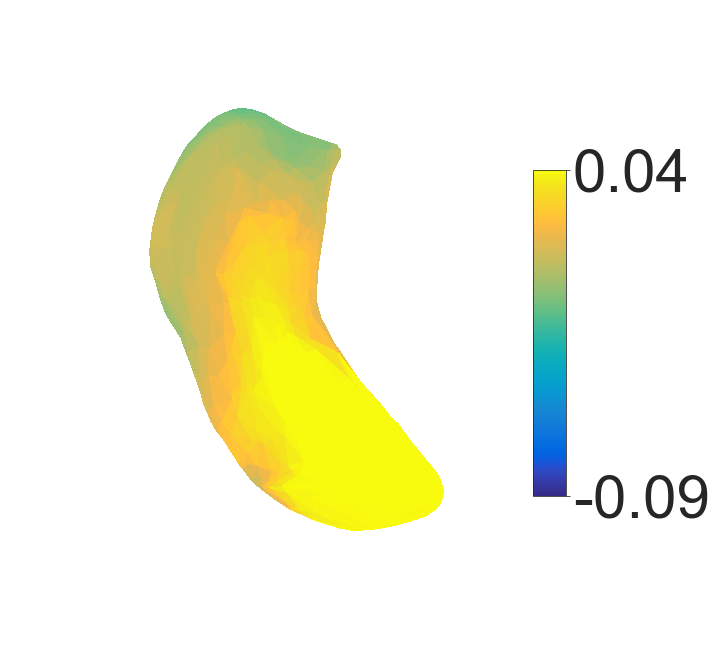

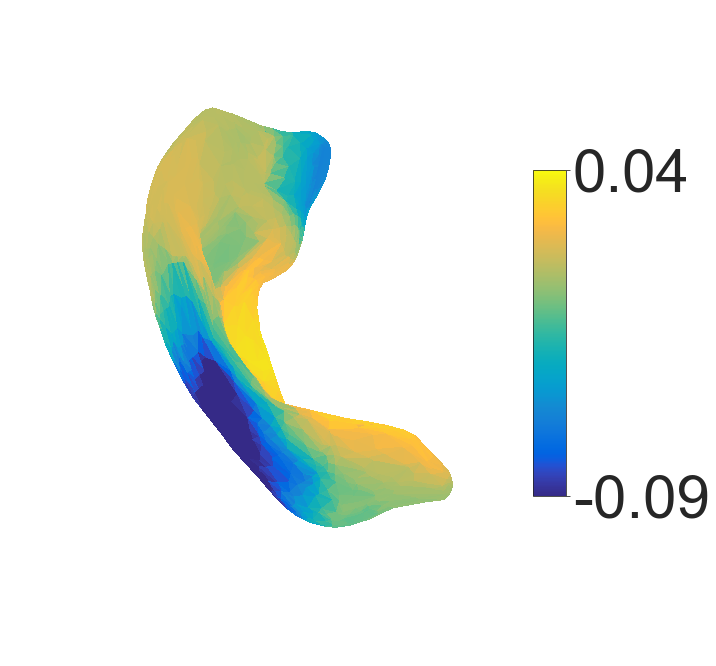

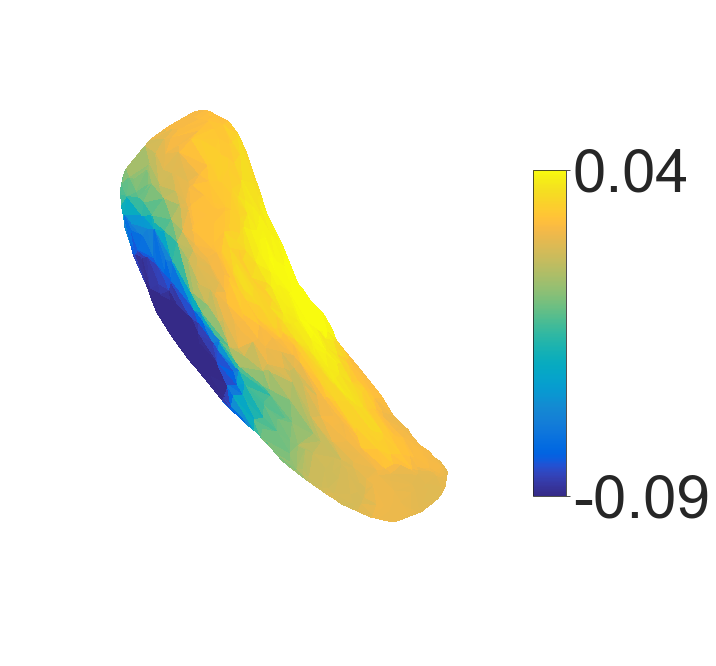

In [8]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G2_sic_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.09, 0.04)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_sic_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.09, 0.04)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_sic_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.09, 0.04)


###  projections of hippocampal G1 (sic) onto the hippocampal-cortical sic

In [10]:
h = h5py.File(os.path.join(ddir, 'Hmean709scov_all.h5'), 'r')
scov_all = np.array(h['data'])

scov_subfield_cortex = scov_all[360:,0:360] 

scov_LSUB_cortex = scov_subfield_cortex[0:1024, :]
scov_LCA_cortex = scov_subfield_cortex[1024:1024+2048, :]
scov_LDG_cortex = scov_subfield_cortex[1024+2048:1024+2048+1024, :]


In [11]:
# get correlations between G1 (sic) and sic

r1_LSUB = np.zeros((360,))
r1_LCA = np.zeros((360,))
r1_LDG = np.zeros((360,))

for k in range(0, 360):
    r1_LSUB[k] = np.corrcoef(scov_LSUB_cortex.T[k,:], G1_sic_LSUB)[-1:,:-1][0,0]
    r1_LCA[k] = np.corrcoef(scov_LCA_cortex.T[k,:], G1_sic_LCA)[-1:,:-1][0,0]
    r1_LDG[k] = np.corrcoef(scov_LDG_cortex.T[k,:], G1_sic_LDG)[-1:,:-1][0,0]
    

In [12]:
# label correlation values to the freesurfer space
r1_LSUB_labeled = map_to_labels(r1_LSUB, labeling, mask=mymask) 
r1_LSUB_labeled[np.where(mymask == False)] = np.nan

r1_LCA_labeled = map_to_labels(r1_LCA, labeling, mask=mymask) 
r1_LCA_labeled[np.where(mymask == False)] = np.nan

r1_LDG_labeled = map_to_labels(r1_LDG, labeling, mask=mymask) 
r1_LDG_labeled[np.where(mymask == False)] = np.nan

print(r1_LSUB_labeled.shape, np.nanmin(r1_LSUB_labeled), np.nanmax(r1_LSUB_labeled))
print(r1_LCA_labeled.shape, np.nanmin(r1_LCA_labeled), np.nanmax(r1_LCA_labeled))    
print(r1_LDG_labeled.shape, np.nanmin(r1_LDG_labeled), np.nanmax(r1_LDG_labeled))    


(64984,) -0.7348118608226778 0.6545107997220674
(64984,) -0.5342529662018423 0.7688247549083955
(64984,) -0.6800768296000574 0.395665644291476


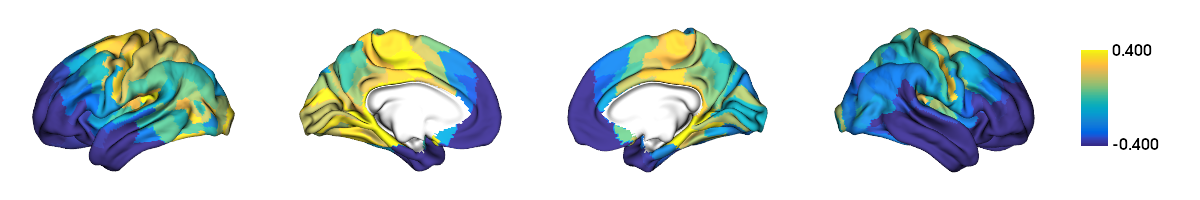

In [13]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_r1_G1_cortex_LSUB.svg',
                 )

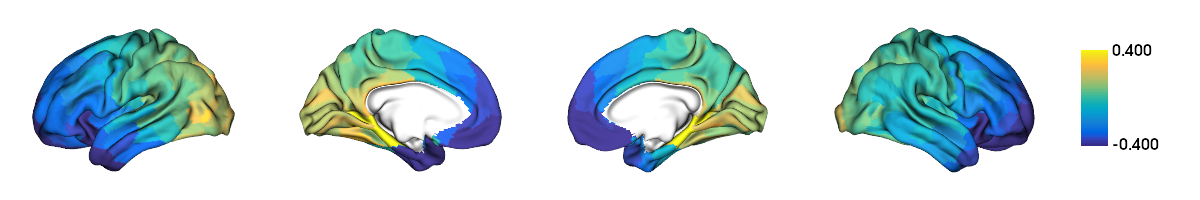

In [14]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_r1_G1_cortex_LCA.svg',
                 )

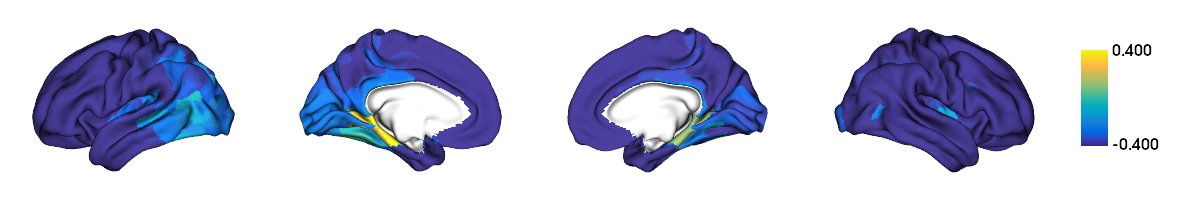

In [15]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_r1_G1_cortex_LDG.svg'                 
                 )
                

### read-in the gradients data of the genetic correlation (gen) 

In [16]:
g = h5py.File(os.path.join(outdir, 'Hmean709genGradients_left.h5'), 'r')
data = np.array(g['data']).T

G1_gen_LSUB = data[0:1024,0]
G1_gen_LCA  = data[1024:1024+2048,0]
G1_gen_LDG  = data[1024+2048:1024+2048+1024,0] 

G2_gen_LSUB = data[0:1024,1]
G2_gen_LCA  = data[1024:1024+2048,1]
G2_gen_LDG  = data[1024+2048:1024+2048+1024,1] 



## G1 (gen)

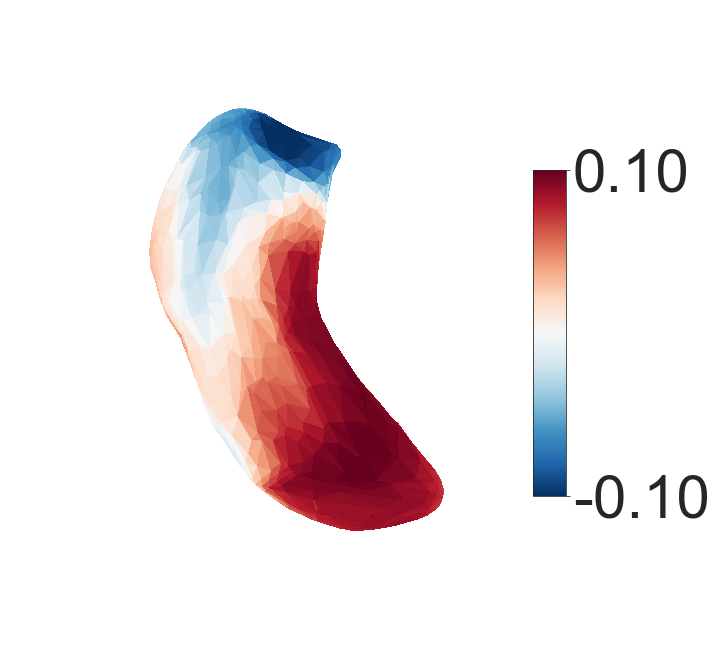

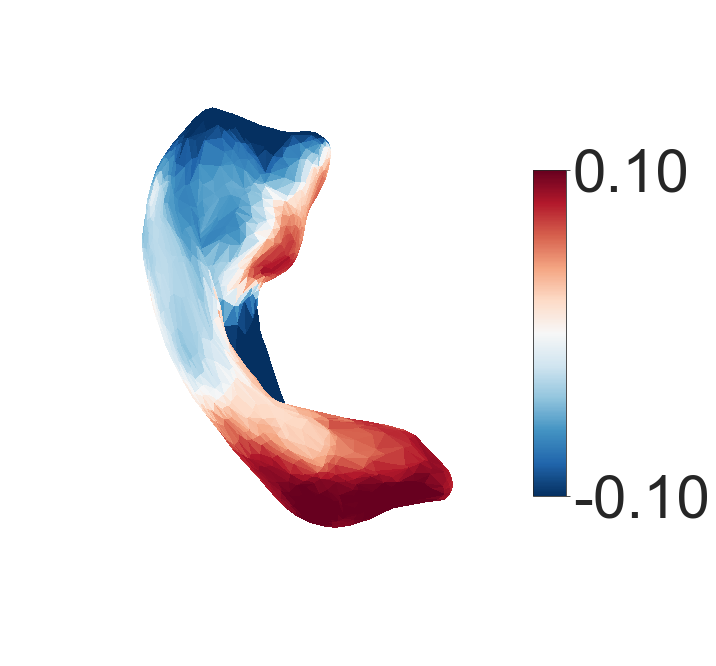

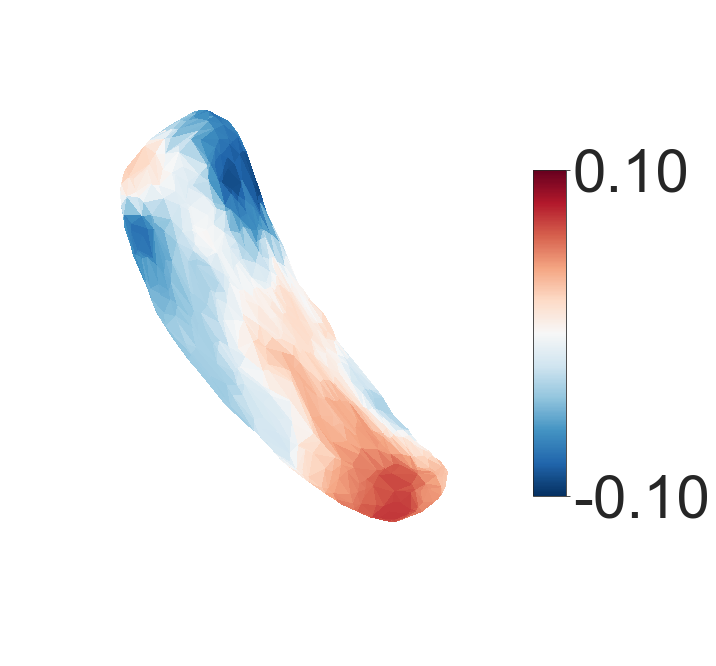

In [17]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB,
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G1_gen_LSUB, 
                                  'RdBu_r', -0.1, 0.1)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_gen_LCA,
                                   'RdBu_r', -0.1, 0.1)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_gen_LDG,
                                   'RdBu_r', -0.1, 0.1)


#fig1.savefig('../figures/gen_G1_lsub.svg', dpi=300)
#fig2.savefig('../figures/gen_G1_lca.svg', dpi=300)
#fig3.savefig('../figures/gen_G1_ldg.svg', dpi=300)

## G2 (gen)

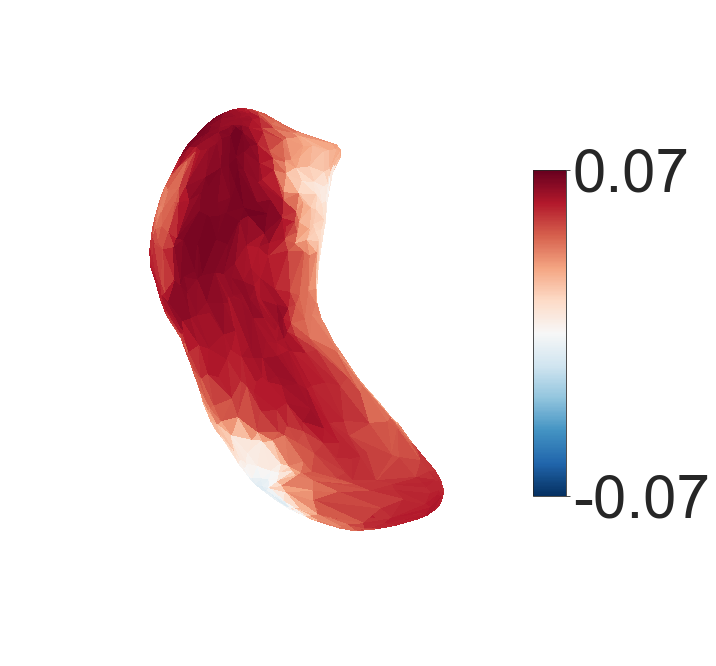

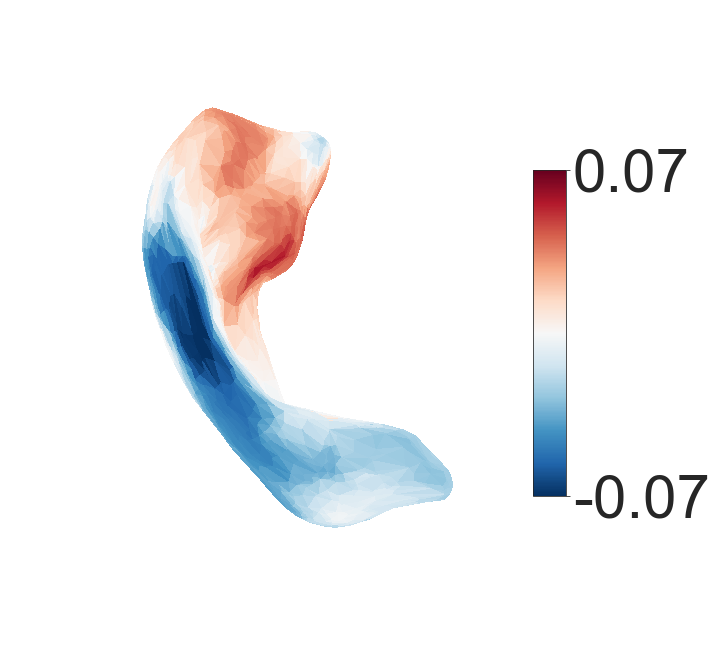

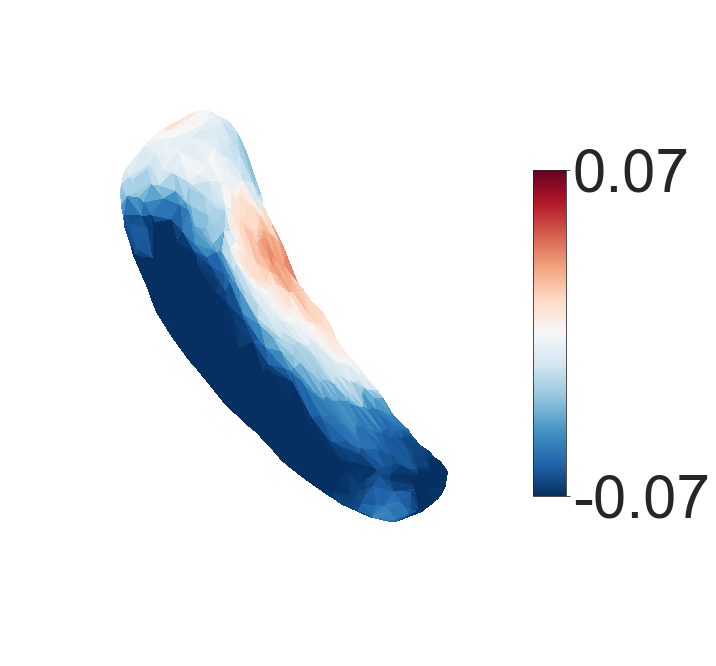

In [18]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB,
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G2_gen_LSUB, 
                                  'RdBu_r', -0.07, 0.07)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_gen_LCA,
                                   'RdBu_r',-0.07, 0.07)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_gen_LDG,
                                   'RdBu_r', -0.07, 0.07)


#fig1.savefig('../figures/gen_G2_lsub.svg', dpi=300)
#fig2.savefig('../figures/gen_G2_lca.svg', dpi=300)
#fig3.savefig('../figures/gen_G2_ldg.svg', dpi=300)

###  projections of hippocampal G1 (gen) onto the hippocampal-cortical gen

In [19]:
h = h5py.File(os.path.join(ddir, 'Hmean709gen_subfields.h5'), 'r')
gen_corr = np.array(h['data'])

print(gen_corr.shape, np.nanmin(gen_corr), np.nanmax(gen_corr))

genncorr_LSUB = gen_corr[:,0:1024]
genncorr_LCA  = gen_corr[:,1024:1024+2048]
genncorr_LDG  = gen_corr[:,1024+2048:1024+2048+1024]


(360, 4096) -0.5069329 1.0


In [20]:
c1_LSUB = np.zeros((360,))
c1_LCA  = np.zeros((360,))
c1_LDG = np.zeros((360,))

for k in range(0, 360):
    c1_LSUB[k] = np.corrcoef(genncorr_LSUB[k,:], G1_gen_LSUB)[-1:,:-1][0,0]
    c1_LCA[k]  = np.corrcoef(genncorr_LCA[k,:], G1_gen_LCA)[-1:,:-1][0,0]
    c1_LDG[k]  = np.corrcoef(genncorr_LDG[k,:], G1_gen_LDG)[-1:,:-1][0,0]

In [21]:
c1_LSUB_labeled = map_to_labels(c1_LSUB, labeling, mask=mymask) 
c1_LSUB_labeled[np.where(mymask == False)] = np.nan

c1_LCA_labeled = map_to_labels(c1_LCA, labeling, mask=mymask) 
c1_LCA_labeled[np.where(mymask == False)] = np.nan

c1_LDG_labeled = map_to_labels(c1_LDG, labeling, mask=mymask) 
c1_LDG_labeled[np.where(mymask == False)] = np.nan

print(c1_LSUB_labeled.shape, np.nanmin(c1_LSUB_labeled), np.nanmax(c1_LSUB_labeled))
print(c1_LCA_labeled.shape, np.nanmin(c1_LCA_labeled), np.nanmax(c1_LCA_labeled))
print(c1_LDG_labeled.shape, np.nanmin(c1_LDG_labeled), np.nanmax(c1_LDG_labeled))

(64984,) -0.8754650499895955 0.7257769053247067
(64984,) -0.879781626001904 0.5933801949013315
(64984,) -0.8086264569481537 0.6559790547261516


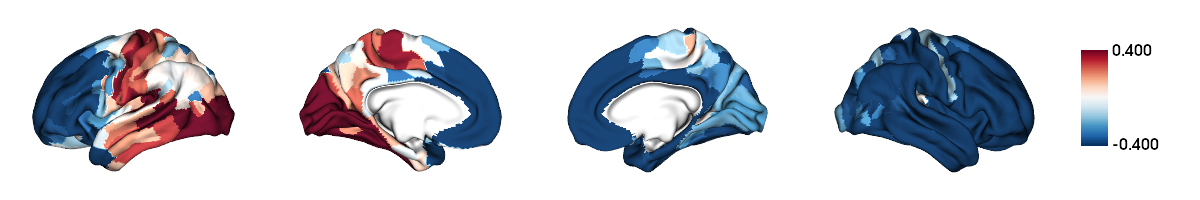

In [22]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_r1_G1_cortex_LSUB.svg'                
                )

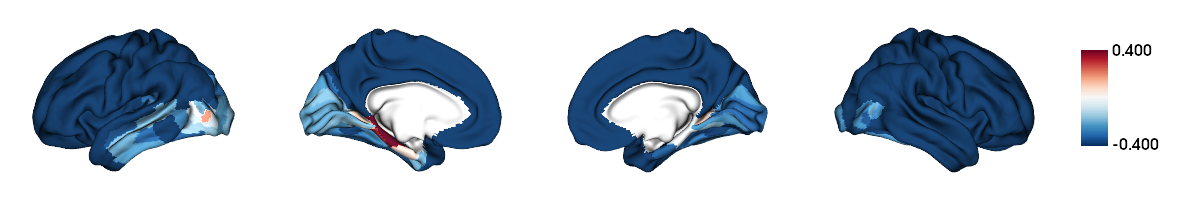

In [23]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_r1_G1_cortex_LCA.svg'
                )

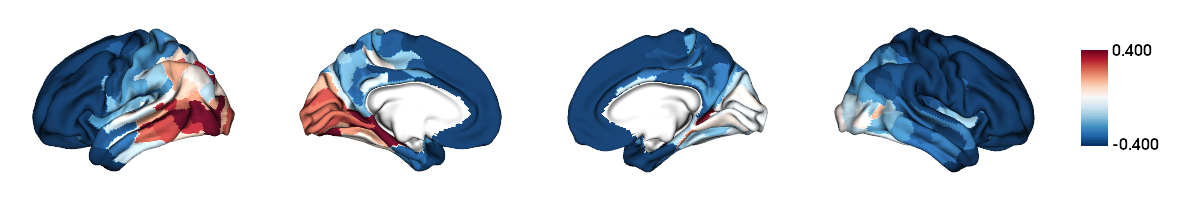

In [24]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_r1_G1_cortex_LDG.svg'               
                )

## similarity between G1 (sic) and G1 (fc)

In [25]:
ddir = '../data/tout_group/'

# read-in primary and secongardy gradients (G1 & G2) for individual subfields
h1  = h5py.File(os.path.join(ddir, 'Hmean709connGradients_left.h5'), 'r');

G1_fc_LSUB = np.array(h1['gradients_'][0:1024,0])
G1_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,0])
G1_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,0])

G2_fc_LSUB = np.array(h1['gradients_'][0:1024,1])
G2_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,1])
G2_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,1])


In [26]:
print(pearsonr(G1_fc_LSUB, G1_sic_LSUB ))
print(pearsonr(G1_fc_LCA, G1_sic_LCA ))
print(pearsonr(G1_fc_LDG, G1_sic_LDG ))


(0.8815639860321456, 0.0)
(0.8630543819132159, 0.0)
(0.876595717217076, 0.0)


In [27]:
print(pearsonr(G2_fc_LSUB, G2_sic_LSUB ))
print(pearsonr(G2_fc_LCA, G2_sic_LCA ))
print(pearsonr(G2_fc_LDG, G2_sic_LDG ))


(0.3595846247888642, 1.2913440173188925e-32)
(0.224216643480447, 9.448377013954833e-25)
(-0.15383892600476762, 7.563531845325534e-07)


### variogram matching to correct p-values for spatial-autocorrelations

In [28]:
from scipy.io import loadmat

ddir = '../data/tout_group/'

# get surface coordinates & triangles
LSUBfile = os.path.join(ddir, 'surf_lsub.mat')
LSUBsurf = loadmat(LSUBfile)['ave_lsub'][0,0]
xLSUB = LSUBsurf['coord'][0,:]           # (1024,)
yLSUB = LSUBsurf['coord'][1,:]           # (1024,)
zLSUB = -LSUBsurf['coord'][2,:]          # (1024,)

LCAfile = os.path.join(ddir, 'surf_lca.mat')
LCAsurf = loadmat(LCAfile)['ave_lca'][0,0];
xLCA = LCAsurf['coord'][0,:]           # (2048,)
yLCA = LCAsurf['coord'][1,:]           # (2048,)
zLCA = -LCAsurf['coord'][2,:]          # (2048,)

LDGfile = os.path.join(ddir, 'surf_ldg.mat')
LDGsurf = loadmat(LDGfile)['ave_ldg'][0,0];
xLDG = LDGsurf['coord'][0,:]           # (1024,)
yLDG = LDGsurf['coord'][1,:]           # (1024,)
zLDG = -LDGsurf['coord'][2,:]          # (1024,)

coord_LSUB = np.concatenate((xLSUB.reshape(1024,1), 
                             yLSUB.reshape(1024,1), 
                             zLSUB.reshape(1024,1)), axis=1)

coord_LCA  = np.concatenate((xLCA.reshape(2048,1), 
                             yLCA.reshape(2048,1), 
                             zLCA.reshape(2048,1)), axis=1)

coord_LDG  = np.concatenate((xLDG.reshape(1024,1), 
                             yLDG.reshape(1024,1), 
                             zLDG.reshape(1024,1)), axis=1)

In [29]:
points_LSUB = np.array(coord_LSUB, dtype='float64')
faces_LSUB  = np.array(LSUBsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LSUB = geodesic.PyGeodesicAlgorithmExact(points_LSUB, faces_LSUB)
distance_LSUB = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LSUB.geodesicDistances(sourceIndex, targetIndex)
    distance_LSUB[i, :] = distIndex

In [30]:
points_LCA = np.array(coord_LCA, dtype='float64')
faces_LCA  = np.array(LCAsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LCA = geodesic.PyGeodesicAlgorithmExact(points_LCA, faces_LCA)
distance_LCA = np.zeros((2048,2048))

for i in range(0, 2048):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LCA.geodesicDistances(sourceIndex, targetIndex)
    distance_LCA[i, :] = distIndex


In [31]:
points_LDG = np.array(coord_LDG, dtype='float64')
faces_LDG  = np.array(LDGsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LDG = geodesic.PyGeodesicAlgorithmExact(points_LDG, faces_LDG)
distance_LDG = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance and the path
    distIndex, best_source = geoalg_LDG.geodesicDistances(sourceIndex, targetIndex)
    distance_LDG[i, :] = distIndex

In [32]:
from scipy.sparse.csgraph import dijkstra

distance_LSUB = dijkstra(distance_LSUB, directed=False)
distance_LSUB_idx_sorted = np.argsort(distance_LSUB, axis=1)

distance_LCA = dijkstra(distance_LCA, directed=False)
distance_LCA_idx_sorted = np.argsort(distance_LCA, axis=1)

distance_LDG = dijkstra(distance_LDG, directed=False)
distance_LDG_idx_sorted = np.argsort(distance_LDG, axis=1)

In [33]:
from brainspace.null_models import SampledSurrogateMaps

n_surrogate_datasets = 1000

# Note: number samples must be greater than number neighbors
num_samples = 100
num_neighbors = 50

ssm_LSUB = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LSUB.fit(distance_LSUB, distance_LSUB_idx_sorted)

ssm_LCA = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LCA.fit(distance_LCA, distance_LCA_idx_sorted)

ssm_LDG = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LDG.fit(distance_LDG, distance_LDG_idx_sorted)


G1_sic_LSUB_surrogates = ssm_LSUB.randomize(G1_sic_LSUB, n_rep=n_surrogate_datasets)
G1_sic_LCA_surrogates = ssm_LCA.randomize(G1_sic_LCA, n_rep=n_surrogate_datasets)
G1_sic_LDG_surrogates = ssm_LDG.randomize(G1_sic_LDG, n_rep=n_surrogate_datasets)

G2_sic_LSUB_surrogates = ssm_LSUB.randomize(G2_sic_LSUB, n_rep=n_surrogate_datasets)
G2_sic_LCA_surrogates = ssm_LCA.randomize(G2_sic_LCA, n_rep=n_surrogate_datasets)
G2_sic_LDG_surrogates = ssm_LDG.randomize(G2_sic_LDG, n_rep=n_surrogate_datasets)


G1_lsub:
 ABC 0.88156 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.86305 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.87660 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00



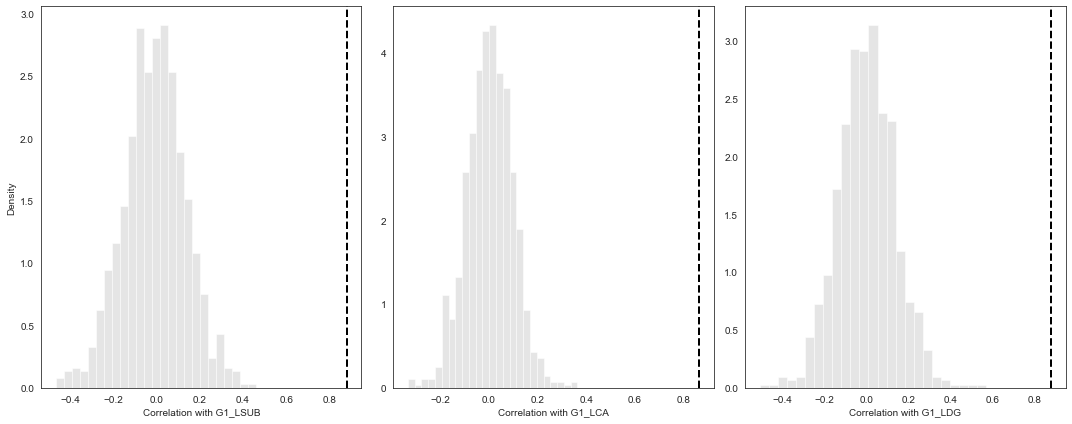

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_sic_LSUB,
         'G1_LCA' : G1_sic_LCA,
         'G1_LDG' : G1_sic_LDG}

rand = {'G1_LSUB': G1_sic_LSUB_surrogates,
           'G1_LCA' : G1_sic_LCA_surrogates,
           'G1_LDG' : G1_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G1_fc_LSUB
                
    if k == 1:
        XG = G1_fc_LCA
        
    if k == 2:
        XG = G1_fc_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

G2_lsub:
 ABC 0.35958 
 Obs      : 1.29134e-32
 Variogram: 1.50000e-02

G2_lca:
 ABC 0.22422 
 Obs      : 9.44838e-25
 Variogram: 1.50000e-02

G2_ldg:
 ABC -0.15384 
 Obs      : 7.56353e-07
 Variogram: 1.93000e-01



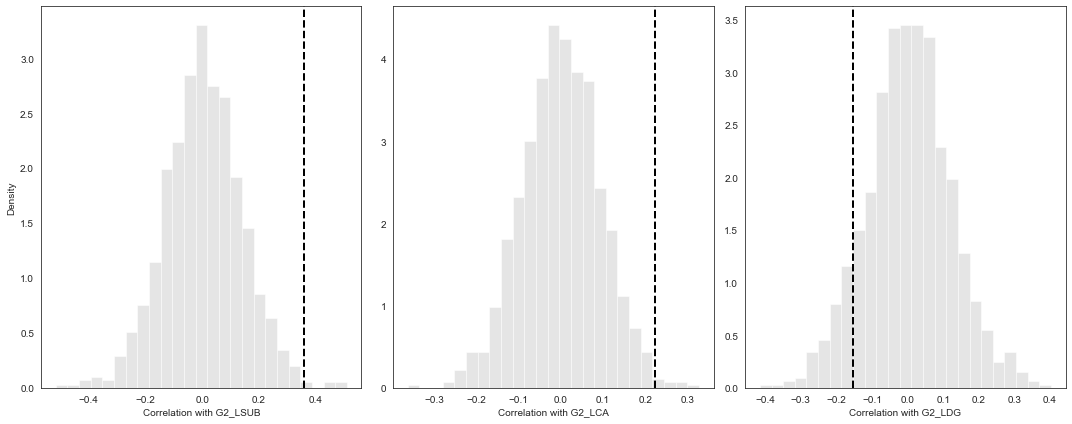

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G2_LSUB': G2_sic_LSUB,
         'G2_LCA' : G2_sic_LCA,
         'G2_LDG' : G2_sic_LDG}

rand = {'G2_LSUB': G2_sic_LSUB_surrogates,
           'G2_LCA' : G2_sic_LCA_surrogates,
           'G2_LDG' : G2_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G2_fc_LSUB
                
    if k == 1:
        XG = G2_fc_LCA
        
    if k == 2:
        XG = G2_fc_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()



## similarities between G1 (gen) and G1 (FC)

In [36]:
print(pearsonr(G1_fc_LSUB, G1_gen_LSUB ))
print(pearsonr(G1_fc_LCA, G1_gen_LCA ))
print(pearsonr(G1_fc_LDG, G1_gen_LDG ))


(0.6711740250041487, 5.052656510806426e-135)
(0.4106185087478693, 3.9225372925258332e-84)
(0.7511077171418354, 1.643587705241546e-186)


In [37]:
G1_gen_LSUB_surrogates = ssm_LSUB.randomize(G1_gen_LSUB, n_rep=n_surrogate_datasets)
G1_gen_LCA_surrogates = ssm_LCA.randomize(G1_gen_LCA, n_rep=n_surrogate_datasets)
G1_gen_LDG_surrogates = ssm_LDG.randomize(G1_gen_LDG, n_rep=n_surrogate_datasets)

G1_lsub:
 ABC 0.67117 
 Obs      : 5.05266e-135
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.41062 
 Obs      : 3.92254e-84
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.75111 
 Obs      : 1.64359e-186
 Variogram: 0.00000e+00



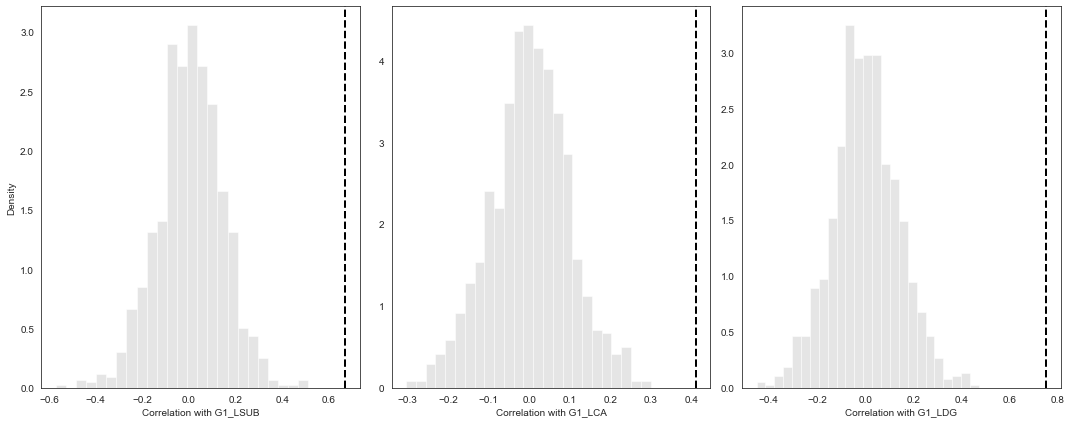

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_gen_LSUB,
         'G1_LCA' : G1_gen_LCA,
         'G1_LDG' : G1_gen_LDG}

rand = {'G1_LSUB': G1_gen_LSUB_surrogates,
           'G1_LCA' : G1_gen_LCA_surrogates,
           'G1_LDG' : G1_gen_LDG_surrogates}

for k, (fn, data) in enumerate(rand.items()):
    if k == 0:
        XG = G1_fc_LSUB   
    if k == 1:
        XG = G1_fc_LCA
    if k == 2:
        XG = G1_fc_LDG
    r_obs, pv_obs = pearsonr(feats[fn], XG)
    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()